In [ ]:
# default_exp model
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# FederatedCustomerPath

> Learning to predict customer journey with a federated setup

***input***: data + tff conversion function from CustomClientData

***output***: TFF model for predicting customer paths 

***description:***

Simulating federated learning on predicting customer paths.

## Import relevant modules

In [ ]:
#
# uncomment this cell to get the newest version of tff

# tensorflow_federated_nightly also bring in tf_nightly, which
# can causes a duplicate tensorboard install, leading to errors.
#!pip uninstall --yes tensorboard tb-nightly

#!pip install --quiet --upgrade tensorflow-federated-nightly
#!pip install --quiet --upgrade nest-asyncio
#!pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

In [ ]:
import numpy as np

import nest_asyncio

nest_asyncio.apply()

You can also view the results using tensorboard:

In [ ]:
%load_ext tensorboard

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

train_test_client_split = tff.simulation.datasets.ClientData.train_test_client_split

tff.federated_computation(lambda: "Hello, World!")()

b'Hello, World!'

In [ ]:
import matplotlib.pyplot as plt
from pyarrow import feather
import pandas as pd

In [ ]:
from ml_federated_customer_path.customclientdata import create_tff_client_data_from_df

## Define notebook parameters

Remember, only simple assignments here!

In [ ]:
# this cell is tagged with 'parameters'
seed = 0
data_filepath = "data/preprocessed_data/data.f"
test_split = 0.2
toy_size = 0.1

NUM_CLIENTS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 100
FEDERATED_UPDATES = 30

Make immediate derivations from the parameters:

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

## Load Data

In [ ]:
df = feather.read_feather(data_filepath)
df

,client_id,x,y
0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",5
1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",6
2,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1
3,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]",8
4,1,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",5
...,...,...,...
45507,9999,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]",5
45508,9999,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]",6
45509,9999,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",2
45510,9999,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1


Convert into tff ClientData (training + testing datasets):

In [ ]:
client_data = create_tff_client_data_from_df(df, sample_size=1)
train_data, test_data = train_test_client_split(
    client_data, int(toy_size * df.client_id.nunique() * test_split)
)

In [ ]:
len(train_data.client_ids)

6134

In [ ]:
len(test_data.client_ids)

200

Clear dataframe as no longer needed:

In [ ]:
df = None

## Explain the math behind

In [ ]:
train_data.element_type_structure

OrderedDict([('x', TensorSpec(shape=(None, 16), dtype=tf.uint8, name=None)),
             ('y', TensorSpec(shape=(None,), dtype=tf.int32, name=None))])

In [ ]:
example_dataset = train_data.create_tf_dataset_for_client(train_data.client_ids[0])

example_element = next(iter(example_dataset))

example_dataset.element_spec
example_element["x"].numpy()

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0,

In [ ]:
example_element = next(iter(example_dataset))

example_dataset.element_spec
example_element["x"].numpy()

array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0,

## Create Federeted ML Process with TFF


In [ ]:
# input layer
def create_keras_model():
    """
    Return new keras model instance
    """
    visible = tf.keras.layers.Input(shape=(16,))

    hidden1 = tf.keras.layers.Dense(256, name="l1linear")(visible)
    hidden2 = tf.keras.layers.Dense(18, activation="sigmoid", name="l2sigmoid")(hidden1)
    output = tf.keras.layers.Dense(9, activation="softmax", name="l3softmax")(hidden2)
    model = tf.keras.Model(inputs=visible, outputs=output)
    return model

In [ ]:
input_size = 16
l1_size = 18
l2_size = 18
l3_size = 9

((input_size + 1) * l1_size + (l1_size + 1) * l2_size + (l2_size + 1) * l3_size)

819

In [ ]:
def model_fn():
    """
    Create tff model (keras model + data format + loss & metrics)
    """
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=collections.OrderedDict(
            x=example_dataset.element_spec["x"],
            y=example_dataset.element_spec["y"],
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

Create federated process:

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=1.0),
)

Initialize:

In [ ]:
state = iterative_process.initialize()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Create federated evaluation process (validation):

In [ ]:
# evaluation
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
iterable = train_data.create_tf_dataset_for_client(train_data.client_ids[1])

In [ ]:
d = next(iter(iterable))
d

OrderedDict([('x',
              <tf.Tensor: shape=(20, 16), dtype=uint8, numpy=
              array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:
train_data.create_tf_dataset_for_client(train_data.client_ids[0])

<PrefetchDataset shapes: OrderedDict([(x, (None, 16)), (y, (None,))]), types: OrderedDict([(x, tf.uint8), (y, tf.int32)])>

In [ ]:
len(train_data.client_ids)

6134

Function for loading client data in batches:

In [ ]:
def batch_client_data(client_data, batch_size=BATCH_SIZE):
    batch = [
        client_data.create_tf_dataset_for_client(client_data.client_ids[idx])
        for idx in np.random.choice(
            np.arange(len(client_data.client_ids)), size=BATCH_SIZE
        )
    ]
    return batch

### Federated training & evaluation:

In [ ]:
state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
test_metrics = evaluation(state.model, batch_client_data(test_data))

print("round  1, metrics={}".format(train_metrics))

metrics_df = pd.DataFrame(
    {
        "federated_update": [0],
        "train_loss": [train_metrics["train"]["loss"]],
        "train_accuracy": [train_metrics["train"]["sparse_categorical_accuracy"]],
        "train_size": [train_metrics["stat"]["num_examples"]],
        "test_loss": [test_metrics["loss"]],
        "test_accuracy": [test_metrics["sparse_categorical_accuracy"]],
    }
)  # , 'test_loss': float, 'test_size':int})

for i in range(FEDERATED_UPDATES):
    state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
    test_metrics = evaluation(state.model, batch_client_data(test_data))
    metrics_df = pd.concat(
        (
            metrics_df,
            pd.DataFrame(
                {
                    "federated_update": [i + 1],
                    "train_loss": [train_metrics["train"]["loss"]],
                    "train_accuracy": [
                        train_metrics["train"]["sparse_categorical_accuracy"]
                    ],
                    "train_size": [train_metrics["stat"]["num_examples"]],
                    "test_loss": [test_metrics["loss"]],
                    "test_accuracy": [test_metrics["sparse_categorical_accuracy"]],
                }
            ),
        ),
        axis=0,
    )
    print("federated_update  {}, metrics={}".format(i + 1, train_metrics))
metrics_df.set_index("federated_update", drop=True, inplace=True)
metrics_df

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.608216), ('loss', 1.1541091)])), ('stat', OrderedDict([('num_examples', 4260)]))])
federated_update  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.2537234), ('loss', 11.486003)])), ('stat', OrderedDict([('num_examples', 3760)]))])
federated_update  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.12232143), ('loss', 11.277099)])), ('stat', OrderedDict([('num_examples', 3360)]))])
federated_update  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy

,train_loss,train_accuracy,train_size,test_loss,test_accuracy
federated_update,,,,,
0,1.154109,0.608216,4260,12.718521,0.162011
1,11.486003,0.253723,3760,11.410460,0.132743
2,11.277099,0.122321,3360,8.308939,0.171642
3,8.827074,0.217254,2840,10.985971,0.121429
4,9.977898,0.130519,3080,8.811869,0.144928
5,7.595474,0.179282,3620,10.126745,0.183673
6,9.552562,0.160897,3120,12.015807,0.162791
7,9.718163,0.282069,2900,9.806708,0.142045
8,8.446747,0.156061,3960,8.814686,0.241935


Plot results:

(0.0, 13.296741718053818)

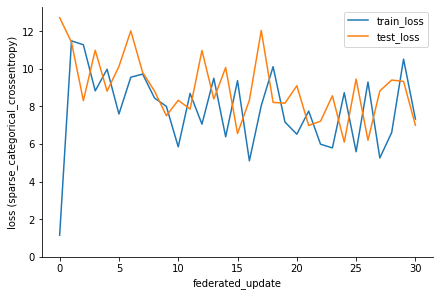

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
metrics_df.plot(ax=ax, y=["train_loss", "test_loss"])
ax.set_ylabel("loss (sparse_categorical_crossentropy)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(ymin=0)

(0.0, 1.0)

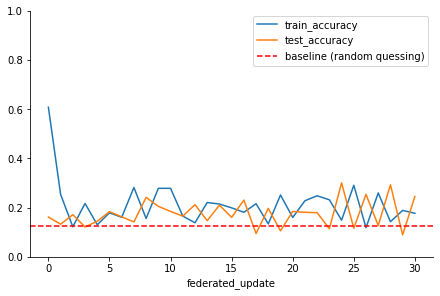

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
metrics_df.plot(ax=ax, y=["train_accuracy", "test_accuracy"])
ax.axhline(1 / 8, linestyle="--", color="r", label="baseline (random quessing)")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, 1)

## Conclusions